# **Library Imports**

In [21]:
import re #libray for regular expression
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!pip install transformers datasets torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install datasets


In [22]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset


# Loading Data

In [23]:
df = pd.read_csv('/content/drive/MyDrive/Github Projects/3. Spam Detection in Emails/completeSpamAssassin.csv')


# **Data Cleaning and Preprocessing**

In [24]:
df

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1
...,...,...,...
6041,6041,empty,0
6042,6042,___ ___ ...,0
6043,6043,IN THIS ISSUE:01. Readers write\n02. Extension...,0
6044,6044,empty,0


In [25]:
# Select relevant columns
df = df[['Body', 'Label']]

df


,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1
...,...,...
6041,empty,0
6042,___ ___ ...,0
6043,IN THIS ISSUE:01. Readers write\n02. Extension...,0
6044,empty,0


In [26]:
df = df.dropna().reset_index(drop=True)

In [27]:
df = df.drop_duplicates().reset_index(drop=True)

In [28]:
df.shape

(5293, 2)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5293 entries, 0 to 5292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    5293 non-null   object
 1   Label   5293 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 82.8+ KB


In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['Body'].tolist(), df['Label'].tolist(), test_size=0.2, random_state=3)


In [36]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


In [37]:
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

In [38]:
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

In [39]:
train_dataset = Dataset.from_dict({
    "text": X_train,
    "labels": y_train,
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
})

test_dataset = Dataset.from_dict({
    "text": X_test,
    "labels": y_test,
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
})

In [40]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
test_dataset.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            1059 non-null   object
 1   labels          1059 non-null   int64 
 2   input_ids       1059 non-null   object
 3   attention_mask  1059 non-null   object
dtypes: int64(1), object(3)
memory usage: 33.2+ KB


In [62]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=500,
    report_to="none"  # Disable Weights & Biases (wandb)
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [66]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert logits to predicted class indices (0 or 1)
    predictions = np.argmax(logits, axis=1)  # Select the class with the highest probability

    # Ensure labels are also in the correct format
    labels = labels.flatten()

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [67]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [68]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.053200,0.163530,0.968839,0.984962,0.900344,0.940754
2,0.023000,0.075316,0.985836,0.966216,0.982818,0.974446
3,0.003300,0.078679,0.987724,0.972789,0.982818,0.977778


TrainOutput(global_step=1590, training_loss=0.025533157512076996, metrics={'train_runtime': 670.6738, 'train_samples_per_second': 18.939, 'train_steps_per_second': 2.371, 'total_flos': 1682600897728512.0, 'train_loss': 0.025533157512076996, 'epoch': 3.0})

In [69]:
results = trainer.evaluate()


In [70]:
print("\nEvaluation Results:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Evaluation Results:
eval_loss: 0.0787
eval_accuracy: 0.9877
eval_precision: 0.9728
eval_recall: 0.9828
eval_f1: 0.9778
eval_runtime: 15.1468
eval_samples_per_second: 69.9160
eval_steps_per_second: 8.7810
epoch: 3.0000


In [71]:
def plot_confusion_matrix(trainer, test_dataset):
    # Get predictions from the model
    logits = trainer.predict(test_dataset).predictions

    # Convert logits to class predictions
    y_pred = np.argmax(logits, axis=1)  # Select the most probable class (0 or 1)
    y_true = np.array(test_dataset["labels"])  # Extract true labels

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()



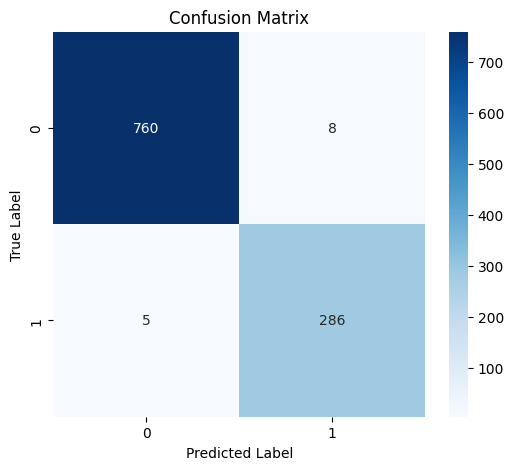

In [72]:
# Display confusion matrix
plot_confusion_matrix(trainer, test_dataset)